**Configuration options**

The configurable options are
*   Type of sentence embedding scheme which decides the input layer dimension
*   Number of visual features used
*   Hidden layer dimension
*   The number of identified output intent types

In [ ]:

# sentence embedding options are 'ConveRT','spacy'
SENTENCE_EMBEDDING_TYPE = 'spacy'    
DROP_OUT_RATE = 0.0 
VISUAL_FEATURES = 4                       # 4 visual features have been identified
                                          # distance from object to agent
                                          # distance from object to receptacle
                                          # distance from agent to receptacle
                                          # angle between the orientation of agent and object

# the input layer dimension depends on the sentence embedding dimension and
# visual features count

if SENTENCE_EMBEDDING_TYPE == 'spacy':
  INPUT_LAYER_DIMENSION = 300 + VISUAL_FEATURES
else:
  INPUT_LAYER_DIMENSION = 1024 + VISUAL_FEATURES


# the hidden layer dimension of the multi-layer perceptron
HIDDEN_LAYER_DIMENSION = 20

# this corresponds to the output layer dimension
LABEL_CLASSES = 16

#
#         {
#          'GotoLocation': 0,
#          'PickupObject': 1,
#          'PutObject': 2,
#          'GotoLocation PickupObject': 3,
#          'GotoLocation PickupObject GotoLocation': 4,
#          'GotoLocation PickupObject GotoLocation PutObject': 5,
#          'PickupObject GotoLocation': 6,
#          'PickupObject GotoLocation PutObject': 7,
#          'GotoLocation PutObject': 8,
#          'GotoLocation PickupObject PutObject': 9,
#          'PickupObject PutObject': 10
#         }
#
#

In [ ]:
TRAIN_MLP_FILE = 'train_mlp_full.txt'
VALIDATION_MLP_FILE = 'dev_mlp_full.txt'
TEST_MLP_FILE = 'test_mlp_full.txt'

In [ ]:
# This cell deals with accessing train and test data from google drive, as the runtime's uploaded data is cleared when the instance is restarted

from google.colab import drive
drive.mount("/content/drive")

# TRAINING FILE LINK
# https://drive.google.com/file/d/1w_9MRJYLZBjU9Y3O6n_BS66yqEIzoI7k/view?usp=sharing

# TESTING FILE LINK
# https://drive.google.com/file/d/1ijEP0TQDN0U5g7JTHKBDKd4ccvGvuInz/view?usp=sharing


TRAIN_MLP_FILE = '/content/drive/My Drive/train_mlp_full.txt'
TEST_MLP_FILE = '/content/drive/My Drive/test_mlp_full.txt'
VALIDATION_MLP_FILE = '/content/drive/My Drive/dev_mlp_full.txt'


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

If using spacy's sentence embedding option, load the spacy's large english model 

In [ ]:
if SENTENCE_EMBEDDING_TYPE == 'spacy':
  import spacy
  !python -m spacy download en_core_web_lg
  
  # restart the runtime if the load fails after download of model
  # nlp = spacy.load('en_core_web_lg')

  # this is an alternative solution only for Colab where the spacy 
  # model is directly imported and loaded
  !pip install en_core_web_lg
  import en_core_web_lg
  nlp = en_core_web_lg.load()

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=c65c48c756fb15670ece679db23e347978a6d89e56b23b5c98209998832d002a
  Stored in directory: /tmp/pip-ephem-wheel-cache-66agpllr/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# !pip install tensorflow==1.14.0
# !pip install tensorflow-gpu==1.14.0
# !pip install --no-deps tensorflow_text==0.1.0


# Import the required dependencies

# import tensorflow as tf
# import tensorflow_text
# import tensorflow_hub as tfhub

If using ConveRT for sentence embedding, download the ConveRT models from poly-ai.com

In [ ]:
#sess = None
#if sess is not None:
#    sess.close()

#sess = tf.InteractiveSession(graph=tf.Graph())

#module = tfhub.Module("https://github.com/PolyAI-LDN/polyai-models/releases/download/v1.0/model.tar.gz")

#text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])
#encoding_tensor = module(text_placeholder)
#encoding_dim = int(encoding_tensor.shape[1])
#print(f"ConveRT encodes text to {encoding_dim}-dimensional vectors")

#sess.run(tf.tables_initializer())
#sess.run(tf.global_variables_initializer())

In [ ]:
from torch.utils.data import Dataset


class MMICDataset(Dataset):

    def __init__(self, filename):
        # Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter='\t')

    def __len__(self):
        return len(self.df)

    def get_embeddings(self, text):
      return sess.run(encoding_tensor, feed_dict={text_placeholder: text})[0]

    def __getitem__(self, index):

        # extract the language information
        desc = self.df.loc[index, 'desc']
        
        # extract the visual information
        dist_to_obj	= self.df.loc[index, 'dist_to_obj']
        dist_to_recep	= self.df.loc[index, 'dist_to_recep']
        dist_obj_to_recep = self.df.loc[index, 'dist_obj_to_recep']
        agent_facing = self.df.loc[index, 'agent_facing']

        # extract the intent
        intent = self.df.loc[index, 'intent']

        if SENTENCE_EMBEDDING_TYPE == 'spacy':
          #  spacy representation
          doc = nlp(desc)
          sentence_rep = doc.vector
        elif SENTENCE_EMBEDDING_TYPE == 'ConveRT':
          # ConveRT representation
          sentence_rep = np.array(self.get_embeddings([desc]))

        if VISUAL_FEATURES > 0:
          visual_data = np.array([dist_to_obj, dist_to_recep, dist_obj_to_recep, agent_facing])
          # concatenate language and visual info
          data_input = np.append(sentence_rep, visual_data)
        else:
          data_input = sentence_rep

        # default all data input to float64 and convert to pytorch tensor
        doc_tensor = torch.from_numpy(data_input).float()
        label_tensor = torch.tensor(int(intent))

        return doc_tensor, label_tensor


In [ ]:
# custom Dataset for train, validation and test
train_set = MMICDataset(filename=TRAIN_MLP_FILE)
validation_set = MMICDataset(filename=VALIDATION_MLP_FILE)
test_set = MMICDataset(filename=TEST_MLP_FILE)

In [ ]:
from torch.utils.data import DataLoader

# Create train, validation and test dataloaders
train_loader = DataLoader(train_set, batch_size=64, num_workers=0, pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=64, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=64, num_workers=0, pin_memory=True)

In [ ]:
# utility method that calculates the accuracy
def accuracy(outputs, labels):
    # the output is a vector of dimension = LABEL_CLASSES
    # here we pick index of the dimension that has the highest value and
    # check if matches the label
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds.tolist()

In [ ]:
def print_stats(pred_label_arrays, actual_label_arrays):
    pred_labels = []
    actual_labels = []

    for arr in pred_label_arrays:
      pred_labels =  pred_labels + arr

    for arr in actual_label_arrays:
      actual_labels = actual_labels + arr

    from sklearn.metrics import confusion_matrix
    confusion = confusion_matrix(actual_labels, pred_labels)
    print('\nConfusion Matrix')
    print(confusion)
    print(precision_recall_fscore_support(actual_labels, pred_labels,
                                      average='macro'))
    print(precision_recall_fscore_support(actual_labels, pred_labels,
                                      average=None,
                                      labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]))
    
    plot_confusion_matrix(cm=confusion,
                      normalize=False,
                      target_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                      title="Confusion Matrix")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class IntentClassifier(nn.Module):

    def __init__(self):
        super(IntentClassifier, self).__init__()

        # input layer that accepts the language and visual features
        self.linear1 = nn.Linear(INPUT_LAYER_DIMENSION, HIDDEN_LAYER_DIMENSION)
        # output layer
        self.linear2 = nn.Linear(HIDDEN_LAYER_DIMENSION, LABEL_CLASSES)
        # self.linear3 = nn.Linear(HIDDEN_LAYER_DIMENSION, LABEL_CLASSES)
        # dropout layer
        self.dropout = nn.Dropout(DROP_OUT_RATE) 

    def forward(self, input_data):

        # feed the input
        out = self.linear1(input_data)
        # Apply RELU activation function
        out = F.relu(out)
        # Add the drop out to increase generalisation
        out = self.dropout(out)
        # feed to the output layer
        out = self.linear2(out)
        # out = F.relu(out)
        # out = self.linear3(out)
        # out = func.softmax(out)
        return out

    # -------------------------------------------------------- #

    def training_step(self, batch):
        sentences, labels = batch 
        out = self(sentences)               
        loss = F.cross_entropy(out, labels) 
        acc, _ = accuracy(out, labels)            
        return {'loss': loss, 'acc': acc}
    
    def validation_step(self, batch):
        sentences, labels = batch 
        out = self(sentences)                          # Generate predictions
        loss = F.cross_entropy(out, labels)            # Calculate the loss
        acc, predicted_labels = accuracy(out, labels)  # Calculate the accuracy
        return {'loss': loss, 'acc': acc, 'pred' : predicted_labels, 'label': labels.tolist()}

    def train_epoch_end(self, outputs, epoch):
        batch_losses = [x['loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        result = {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}
        display(epoch, result, 'train')
        return result
        
    def validation_epoch_end(self, outputs, epoch):
        batch_losses = [x['loss'] for x in outputs]
        pred_label_arrays = [x['pred'] for x in outputs]
        actual_label_arrays = [x['label'] for x in outputs]

        print_stats(pred_label_arrays, actual_label_arrays)

        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        result = {'loss': epoch_loss.item(), 'acc': epoch_acc.item()}
        display(epoch, result, 'validation')
        return result


    def display(self, epoch, result, type):
        print(type)
        print("Epoch [{}], loss: {:.4f}, acc: {:.4f}".format(epoch, result['loss'], result['acc']))    

In [ ]:
model = IntentClassifier()

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([20, 304])
torch.Size([20])
torch.Size([16, 20])
torch.Size([16])


In [ ]:
for desc_commands, labels in train_loader:
    outputs = model(desc_commands)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break


Loss: 2.7510571479797363


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print(device)


def to_device(data, device):
    # Move tensors to the chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


for desc_commands, label in train_loader:
    # input is taken in batches and the shape of desc_commands
    # should be BATCH_SIZE x INPUT_LAYER_DIMENSION 
    print(desc_commands.shape)
    desc_commands = to_device(desc_commands, device)
    print(desc_commands.device)
    break



class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        print('init')
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


cpu
torch.Size([64, 304])
cpu


In [ ]:
# load data into GPU
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

for xb, yb in validation_loader:
  print('xb.device:', xb.device)
  print('xb: ', xb)
  print('yb: ', yb)
  break

init
init
init
xb.device: cpu
xb:  tensor([[ 0.1533, -0.0582, -0.1381,  ...,  2.6900,  3.3100,  1.0000],
        [ 0.1533, -0.0582, -0.1381,  ...,  1.4900,  0.3200,  1.0000],
        [ 0.1533, -0.0582, -0.1381,  ...,  3.3100,  3.5100,  0.5900],
        ...,
        [ 0.3743,  0.0713,  0.0373,  ...,  0.3700,  5.2500, -0.2700],
        [ 0.3373, -0.0306, -0.1370,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.1905, -0.0158, -0.0594,  ...,  1.4500,  0.0500,  0.6600]])
yb:  tensor([ 5,  9,  7, 10,  5,  9, 14, 10,  5,  9,  7, 10,  0, 11,  0,  2,  0, 11,
         0, 12,  0, 11,  0, 12,  3,  4,  5,  6,  7,  8,  3,  4,  5, 15,  7,  8,
         3,  4,  5,  6,  7,  8,  5,  9, 14, 13,  5,  9, 14, 13,  5,  9, 14, 10,
         0, 11,  0, 12,  0,  1,  0, 12,  0,  1])


In [ ]:
def evaluate(model, val_loader, epoch):
    model.eval()                            # set the modules in evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs, epoch)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    validation_history = []
    train_history = []
    # MOMENTUM WAS RECENTLY ADDED
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        train_outputs = []
        model.train(True)                        # set modules in training mode
        for batch in train_loader:
            train_output = model.training_step(batch)
            train_outputs.append(train_output)
            train_output['loss'].backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Training phase
        train_result = model.train_epoch_end(train_outputs, epoch)
        train_history.append(train_result)
        # Validation phase
        result = evaluate(model, val_loader, epoch)
        validation_history.append(result)
    return train_history, validation_history

In [ ]:
# run on GPU
model = IntentClassifier()
to_device(model, device)

IntentClassifier(
  (linear1): Linear(in_features=304, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=16, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metric(data_set_type, metric, data):
  plt.plot(data, '-x')
  plt.xlabel('epoch')
  plt.ylabel(data_set_type + ' ' + metric)
  plt.title(metric + ' vs Epochs');
  plt.show()

In [ ]:
def plot_history_metrics(history, dataset_type):
  accuracies = [x['acc'] for x in history]
  plot_metric(dataset_type, 'Accuracy', accuracies)
  losses = [x['loss'] for x in history]
  plot_metric(dataset_type, 'Loss', losses)

In [ ]:
#history = [evaluate(model, validation_loader)]
train_history = []
validation_history = []

In [ ]:
def train_and_validate_model(epochs, learning_rate, model, train_loader, validation_loader, train_history, validation_history):
  train_hist, validation_hist = fit(epochs, learning_rate, model, train_loader, validation_loader)
  train_history = train_history + train_hist
  validation_history = validation_history + validation_hist
  plot_history_metrics(train_history, 'Train')
  plot_history_metrics(validation_history, 'Validation')
  return train_history, validation_history

0

{'acc': 0.7509804368019104, 'loss': 0.7378298044204712}

'train'


Confusion Matrix
[[3416    3    0  162    0    0    0    0    0    0    0    0    3    0
     0    3]
 [   2  768    1    0    0    0   49    1    8    0    0   43    0    0
     0    0]
 [ 107   14  560    0    0    6   22    0   49    0    3    5   94    0
     0    0]
 [   3   18    0 1735    0    0    0    0    0    0    0   42    0    0
     0    0]
 [   3    0    0   69 1397  200   39    0    0   39    0    0    0    0
     6   36]
 [   0    6    6    0 1277 1920   42   12    0  246    3    0    0    0
    33   33]
 [  16    3    0    0    0    0  840   17    0    0    5    2    0    0
     0   15]
 [   0    0    0    0    0    0 1037  641    0    0   49    0    0    1
    28    5]
 [   0  267    8    0    0    0  299   10 1205    0    0    0    0    0
     0    0]
 [   0    1    0    0    2    3    5    4    0 1752   13    0    0   24
     3    0]
 [   0    0    0    0    0    0   25    0    0    0  860    0    0    8
     0    4]
 [   0   19    0    0   21    4    6    0   37 

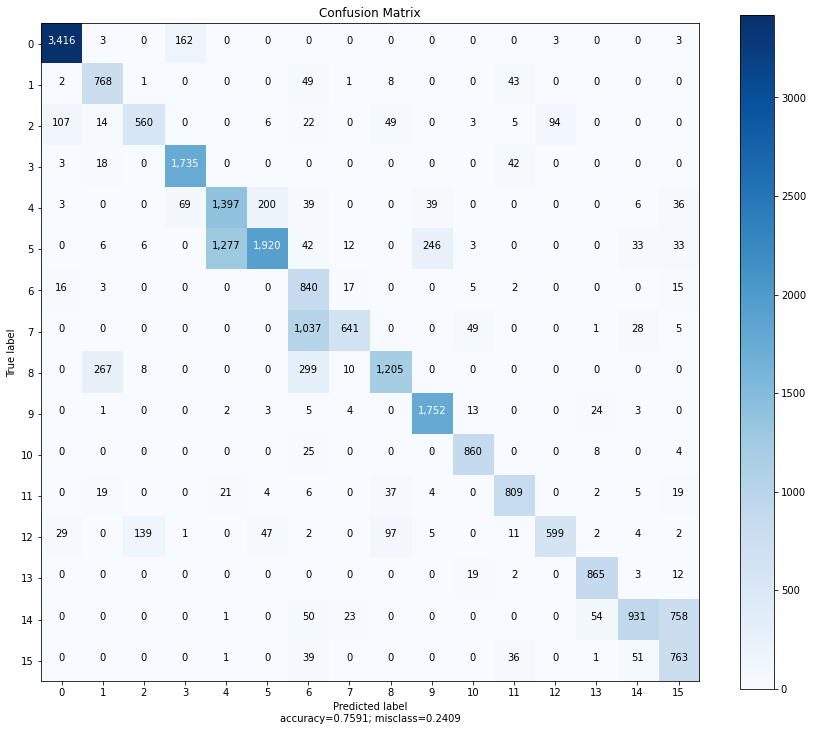

0

{'acc': 0.75897216796875, 'loss': 0.6556306481361389}

'validation'

1

{'acc': 0.8316451907157898, 'loss': 0.4827927052974701}

'train'


Confusion Matrix
[[3425    3    3  153    0    0    0    0    0    0    0    3    0    0
     0    0]
 [   1  830    1    0    1    3   15    3    4    0    0   14    0    0
     0    0]
 [  78    7  737    0    0    3    1    0    5    0    2    0   27    0
     0    0]
 [   6   18    0 1735    0    0    3    0    0    0    0   36    0    0
     0    0]
 [   3    0    6   69 1289  338   36    0    0   15    0    0    0    0
     6   27]
 [   0    0   18    0  812 2538   30    3    0  114    6    0    0    0
    39   18]
 [   7    4    0    0    0    1  840   30    0    0    5    0    0    0
     0   11]
 [   0    0    0    0    0    0  729  930    0    0   59    0    0    1
    39    3]
 [   0  115    4    0    0    0  194   54 1418    0    4    0    0    0
     0    0]
 [   0    2    0    0    1    0    3    0    0 1756   18    0    0   26
     1    0]
 [   0    0    0    0    0    0   26    0    0    0  867    0    0    3
     0    1]
 [   0   16    0    0    0    3    0    0   12 

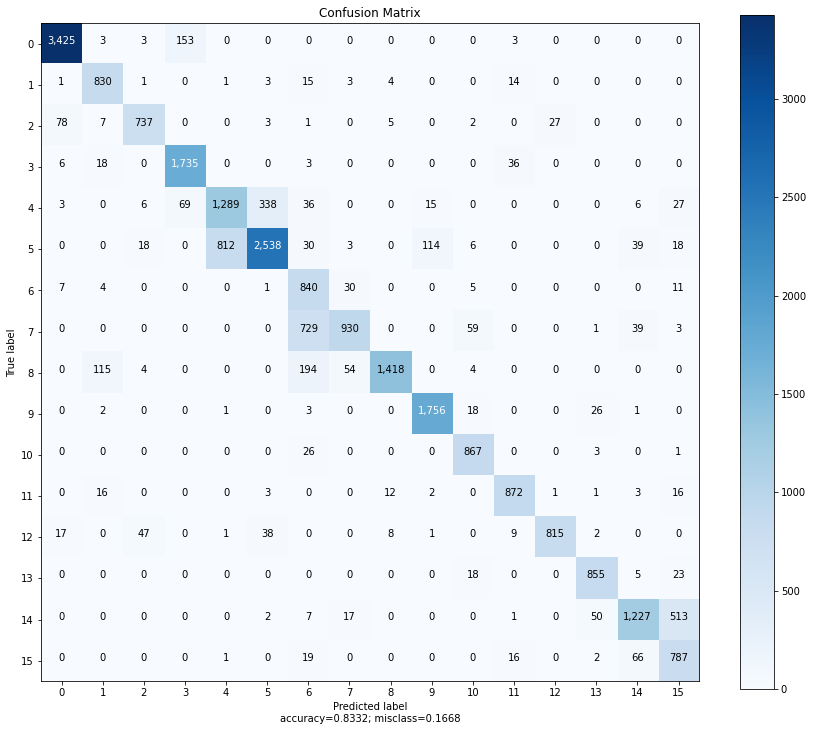

1

{'acc': 0.8330039381980896, 'loss': 0.44911718368530273}

'validation'

2

{'acc': 0.8658400177955627, 'loss': 0.37283411622047424}

'train'


Confusion Matrix
[[3401    3    3  141    0    0    0    0    0    0    0    0   39    0
     0    0]
 [   1  830    1    0    1    7   16    2    5    0    0    9    0    0
     0    0]
 [   5    1  842    0    0    0    0    0    6    0    1    0    5    0
     0    0]
 [   9   12    0 1744    0    0    3    0    0    0    3   24    0    0
     0    3]
 [   3    3    0   69 1364  296   15    0    0   12    0    0    0    0
     3   24]
 [   0    0    6    0  758 2598    9    6    0  135   12    0    0    0
    42   12]
 [   0   11    0    0    0    0  842   26    0    0   11    0    0    0
     0    8]
 [   0   10    0    0    0    2  659  969    4    0   65    0    0    1
    47    4]
 [   0   27    1    0    0    0  145   86 1527    0    3    0    0    0
     0    0]
 [   0    0    0    0    1    1    0    0    0 1759   19    0    0   27
     0    0]
 [   0    0    0    0    0    0   14    0    1    0  877    0    0    4
     0    1]
 [   0    6    0    0    0    1    0    0   12 

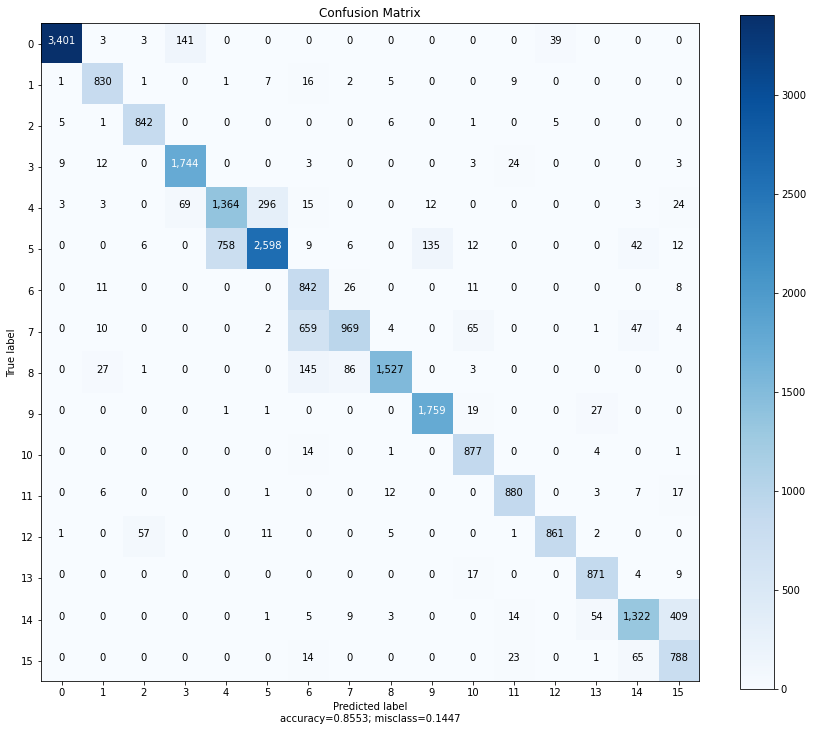

2

{'acc': 0.8551927804946899, 'loss': 0.39100950956344604}

'validation'

3

{'acc': 0.8793734312057495, 'loss': 0.34009599685668945}

'train'


Confusion Matrix
[[3428    3    9  141    0    0    0    0    0    0    0    0    6    0
     0    0]
 [   1  830    2    1    0    1   14    8    3    0    0   12    0    0
     0    0]
 [   2    0  856    0    0    0    0    0    0    0    2    0    0    0
     0    0]
 [   3    0    0 1780    0    0    0    0    0    0    0   15    0    0
     0    0]
 [   3    0    0   69 1292  377   12    0    0   12    0    0    0    0
     0   24]
 [   0    0   15    0  623 2733    6    0    0  138    9    0    0    0
    39   15]
 [   0    3    0    0    0    0  830   48    0    0   12    0    0    0
     0    5]
 [   0    0    0    0    0    0  531 1150    0    0   71    0    0    0
     8    1]
 [   0    8   31    0    0    0   43   99 1605    0    3    0    0    0
     0    0]
 [   0    0    0    0    0    1    0    0    0 1773    8    0    0   24
     1    0]
 [   0    1    0    0    0    0    7    0    0    0  888    0    0    0
     0    1]
 [   0   11    0    0    0    1    0    0   12 

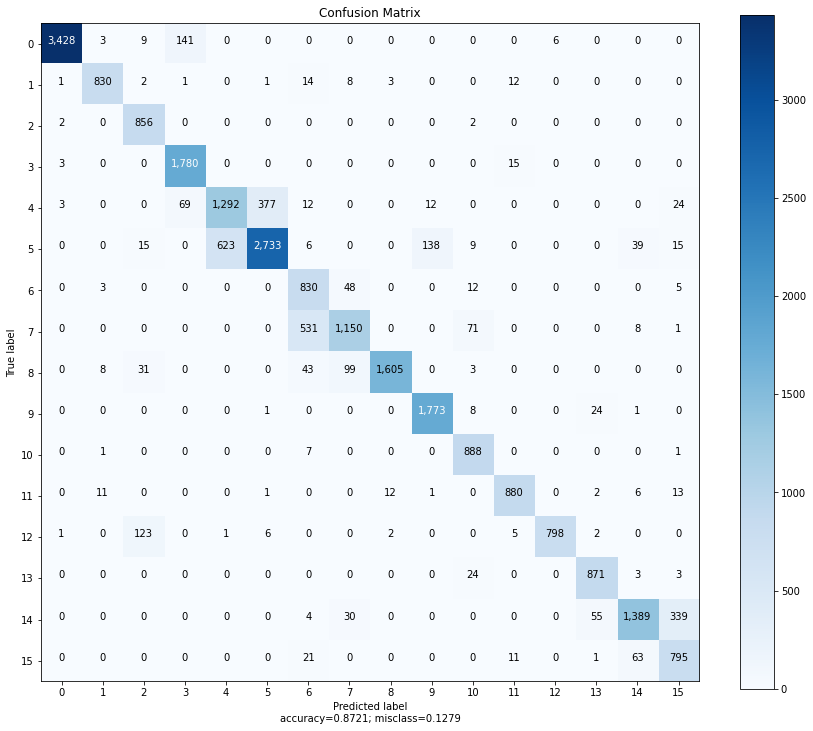

3

{'acc': 0.8720919489860535, 'loss': 0.34858906269073486}

'validation'

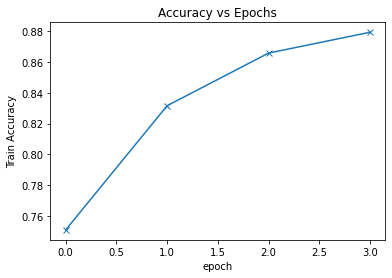

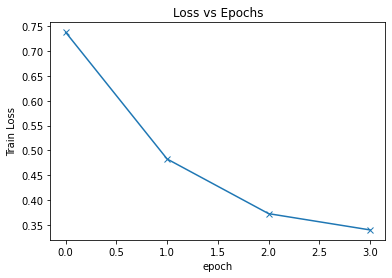

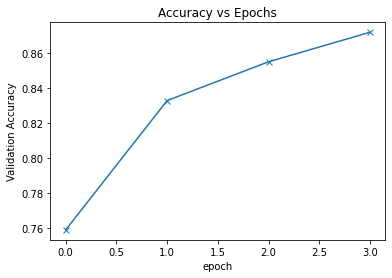

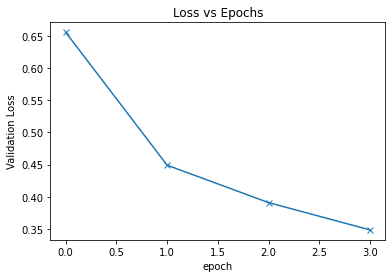

In [ ]:
train_history, validation_history =  train_and_validate_model(4, 0.5, model, train_loader, validation_loader, train_history, validation_history)

Plot the training accuracy and loss accuracy

In [ ]:
print(validation_history)
print(train_history)

[{'loss': 0.6556306481361389, 'acc': 0.75897216796875}, {'loss': 0.44911718368530273, 'acc': 0.8330039381980896}, {'loss': 0.39100950956344604, 'acc': 0.8551927804946899}, {'loss': 0.34858906269073486, 'acc': 0.8720919489860535}]
[{'loss': 0.7378298044204712, 'acc': 0.7509804368019104}, {'loss': 0.4827927052974701, 'acc': 0.8316451907157898}, {'loss': 0.37283411622047424, 'acc': 0.8658400177955627}, {'loss': 0.34009599685668945, 'acc': 0.8793734312057495}]


0

{'acc': 0.9171561002731323, 'loss': 0.22516115009784698}

'train'


Confusion Matrix
[[3440    3    0  138    3    0    0    0    0    0    0    0    3    0
     0    0]
 [   1  851    0    1    1    1   10    4    1    0    0    2    0    0
     0    0]
 [   4    0  854    0    1    0    0    0    0    0    1    0    0    0
     0    0]
 [   3    0    0 1780    0    0    0    0    0    0    0   15    0    0
     0    0]
 [   3    0    0   69 1293  376    9    0    0   15    0    0    0    0
     3   21]
 [   0    0    3    0  396 2993    3    0    0  123   12    0    0    0
    48    0]
 [   2    5    0    0    0    0  807   70    0    0   10    0    0    0
     0    4]
 [   0    0    0    0    0    0  344 1333    6    0   68    0    0    1
     9    0]
 [   0   12   21    0    0    0   12   78 1663    0    3    0    0    0
     0    0]
 [   0    0    0    0    0    1    0    0    0 1779    6    0    0   20
     1    0]
 [   0    0    0    0    0    0    5    0    0    0  890    0    0    2
     0    0]
 [   0   14    0    0    0    1    0    0    7 

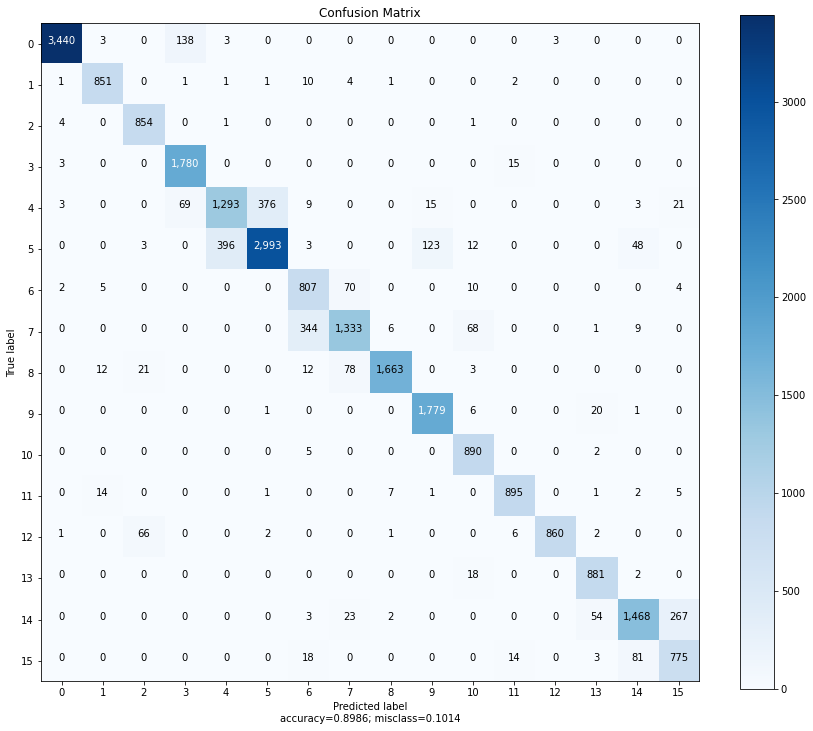

0

{'acc': 0.8987357020378113, 'loss': 0.28373709321022034}

'validation'

1

{'acc': 0.9212151765823364, 'loss': 0.21438293159008026}

'train'


Confusion Matrix
[[3437    3    0  141    3    0    0    0    0    0    0    0    3    0
     0    0]
 [   1  853    0    2    1    0    8    4    1    0    0    2    0    0
     0    0]
 [   3    0  855    0    1    0    0    0    0    0    1    0    0    0
     0    0]
 [   3    0    0 1780    0    0    0    0    0    0    0   15    0    0
     0    0]
 [   3    0    0   69 1218  451    6    0    0   18    0    0    0    0
     0   24]
 [   0    0    3    0  291 3095    3    6    0  120   12    0    0    0
    48    0]
 [   1    4    0    0    0    0  802   79    0    0   11    0    0    0
     0    1]
 [   0    0    0    0    0    0  257 1425    6    0   68    0    0    0
     5    0]
 [   0    3   18    0    0    0    6   62 1697    0    3    0    0    0
     0    0]
 [   0    0    0    0    0    2    0    0    0 1776    6    0    0   23
     0    0]
 [   0    0    0    0    0    0    3    0    0    0  894    0    0    0
     0    0]
 [   0   18    0    0    0    0    0    0    9 

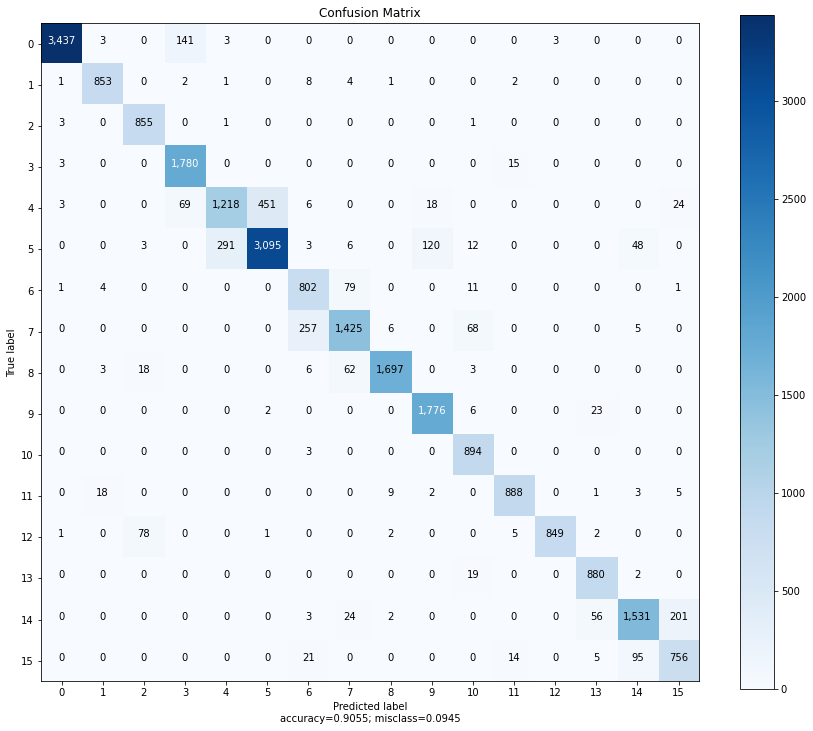

1

{'acc': 0.9056536555290222, 'loss': 0.2720632255077362}

'validation'

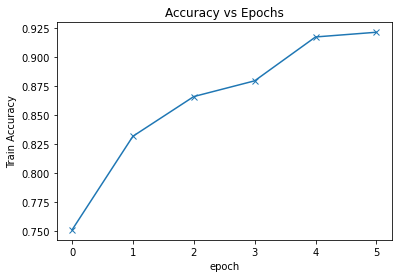

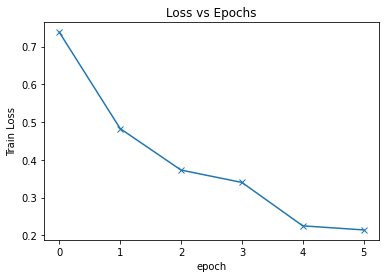

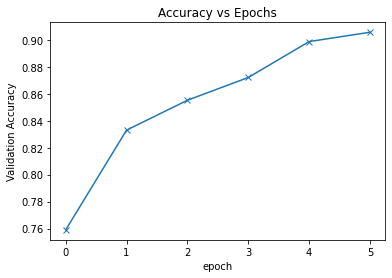

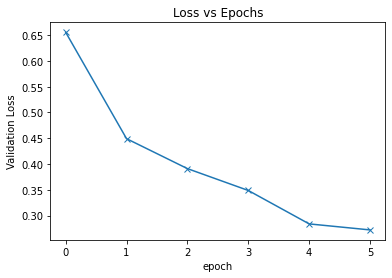

In [ ]:
train_history, validation_history =  train_and_validate_model(2, 0.3, model, train_loader, validation_loader, train_history, validation_history)

In [ ]:
print(train_history)
print(validation_history)

[{'loss': 0.7378298044204712, 'acc': 0.7509804368019104}, {'loss': 0.4827927052974701, 'acc': 0.8316451907157898}, {'loss': 0.37283411622047424, 'acc': 0.8658400177955627}, {'loss': 0.34009599685668945, 'acc': 0.8793734312057495}, {'loss': 0.22516115009784698, 'acc': 0.9171561002731323}, {'loss': 0.21438293159008026, 'acc': 0.9212151765823364}]
[{'loss': 0.6556306481361389, 'acc': 0.75897216796875}, {'loss': 0.44911718368530273, 'acc': 0.8330039381980896}, {'loss': 0.39100950956344604, 'acc': 0.8551927804946899}, {'loss': 0.34858906269073486, 'acc': 0.8720919489860535}, {'loss': 0.28373709321022034, 'acc': 0.8987357020378113}, {'loss': 0.2720632255077362, 'acc': 0.9056536555290222}]


In [ ]:
# torch.save(model.state_dict(), 'mlp_100_train_no_visual.model')

0

{'acc': 0.9397340416908264, 'loss': 0.16875705122947693}

'train'


Confusion Matrix
[[3503    3    0   78    0    0    0    0    0    0    0    0    3    0
     0    0]
 [   1  856    0    2    1    0    8    3    0    1    0    0    0    0
     0    0]
 [   3    0  854    0    1    0    0    0    0    0    1    0    1    0
     0    0]
 [   9    0    0 1783    0    0    0    0    0    0    0    6    0    0
     0    0]
 [   6    0    0   66 1311  361    6    0    0   18    0    0    0    0
     3   18]
 [   0    0    3    0  354 3041    0    0    0  123    9    0    0    0
    48    0]
 [   2    4    0    0    0    0  773  110    0    0    9    0    0    0
     0    0]
 [   0    0    0    0    0    0  176 1527    5    0   52    0    0    0
     1    0]
 [   0    4   15    0    0    0    3   56 1708    0    3    0    0    0
     0    0]
 [   0    0    0    0    0    2    0    0    0 1794    2    0    0    9
     0    0]
 [   0    0    0    0    0    0    1    4    0    1  891    0    0    0
     0    0]
 [   0   15    0    0    0    0    0    0    7 

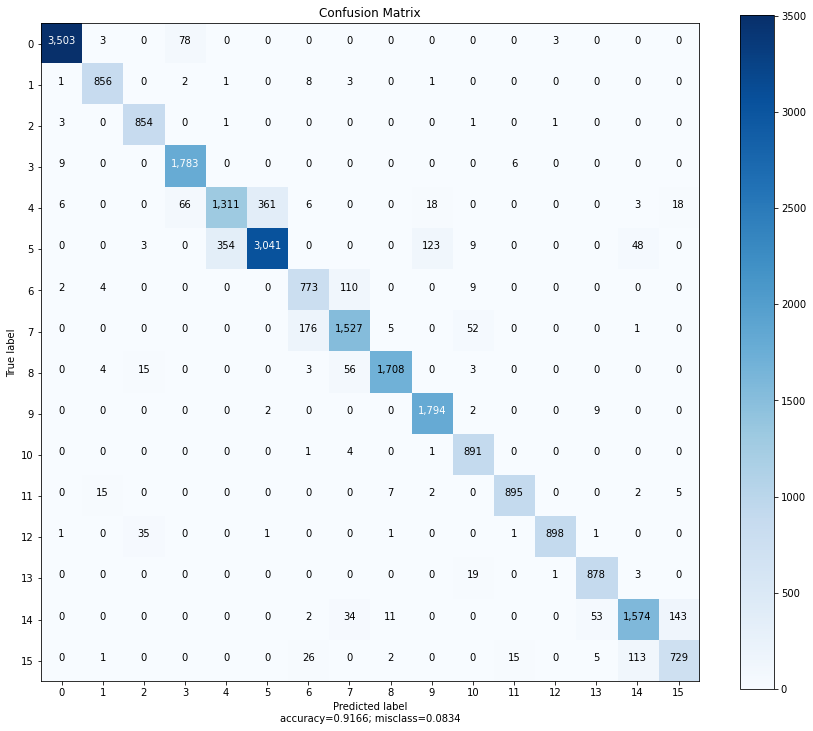

0

{'acc': 0.916746199131012, 'loss': 0.2227606475353241}

'validation'

1

{'acc': 0.9425324201583862, 'loss': 0.16122229397296906}

'train'


Confusion Matrix
[[3509    3    0   75    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  856    0    2    1    0    8    3    0    1    0    0    0    0
     0    0]
 [   3    1  854    0    0    0    0    0    0    0    1    0    1    0
     0    0]
 [   9    0    0 1783    0    0    0    0    0    0    0    6    0    0
     0    0]
 [   6    0    0   66 1288  384    6    0    0   18    0    0    0    0
     3   18]
 [   0    0    3    0  288 3110    0    3    0  123    6    0    0    0
    45    0]
 [   2    4    0    0    0    0  758  125    0    0    9    0    0    0
     0    0]
 [   0    0    0    0    0    0  136 1567    5    0   52    0    0    0
     1    0]
 [   0    2   16    0    0    0    0   51 1717    0    3    0    0    0
     0    0]
 [   0    0    0    0    0    3    0    0    0 1792    2    0    0   10
     0    0]
 [   0    0    0    0    0    0    1    5    0    1  890    0    0    0
     0    0]
 [   0   15    0    0    0    0    0    0    6 

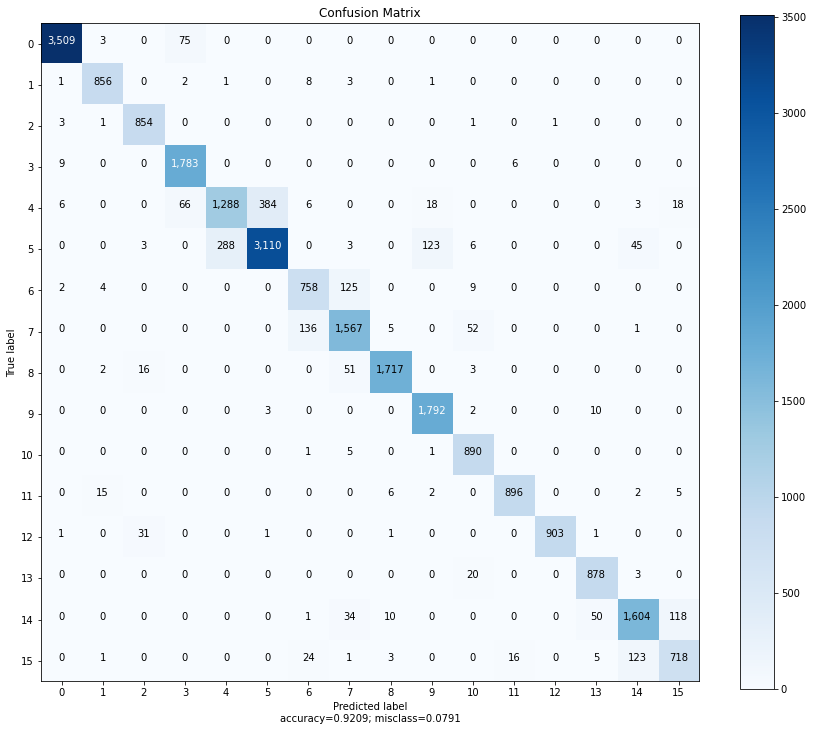

1

{'acc': 0.9210400581359863, 'loss': 0.2151496261358261}

'validation'

2

{'acc': 0.9450060725212097, 'loss': 0.1560327559709549}

'train'


Confusion Matrix
[[3509    3    0   75    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  856    0    2    1    0    8    3    0    1    0    0    0    0
     0    0]
 [   3    1  855    0    0    0    0    0    0    0    1    0    0    0
     0    0]
 [   9    0    0 1786    0    0    0    0    0    0    0    3    0    0
     0    0]
 [   6    0    0   66 1273  405    3    0    0   18    0    0    0    0
     3   15]
 [   0    0    3    0  258 3143    0    3    0  120    6    0    0    0
    45    0]
 [   1    5    0    0    0    0  752  131    0    0    9    0    0    0
     0    0]
 [   0    0    0    0    0    0  117 1587    5    0   51    0    0    1
     0    0]
 [   0    2   16    0    0    0    0   51 1717    0    3    0    0    0
     0    0]
 [   0    0    0    0    0    3    0    0    0 1792    2    0    0   10
     0    0]
 [   0    0    0    0    0    0    1    5    0    1  890    0    0    0
     0    0]
 [   0   15    0    0    0    0    0    0    5 

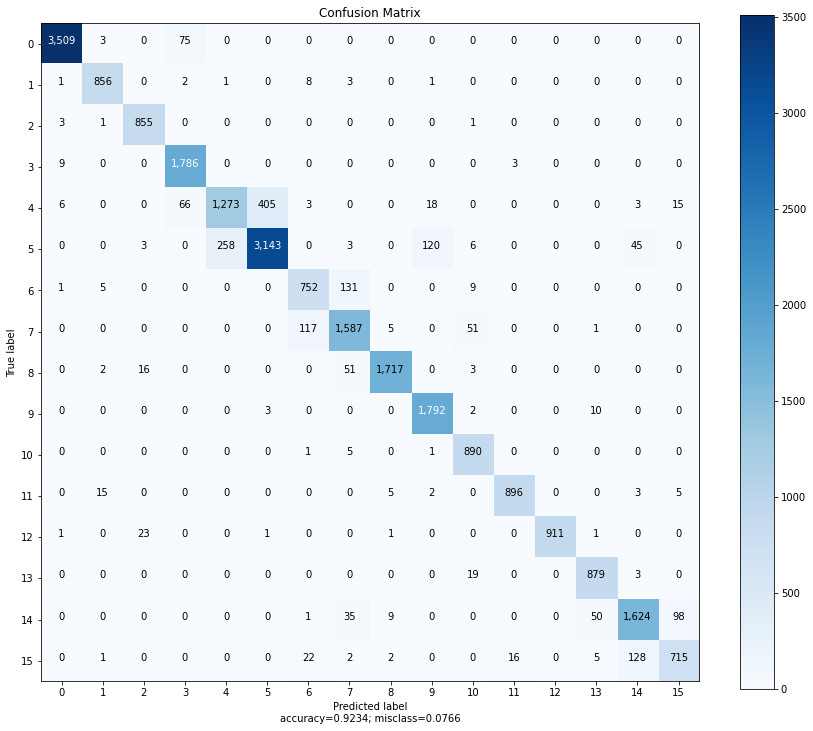

2

{'acc': 0.9235050678253174, 'loss': 0.2103743851184845}

'validation'

3

{'acc': 0.9465437531471252, 'loss': 0.1522246152162552}

'train'


Confusion Matrix
[[3509    3    0   75    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  858    0    2    0    0    7    3    0    1    0    0    0    0
     0    0]
 [   3    1  855    0    0    0    0    0    0    0    1    0    0    0
     0    0]
 [   9    0    0 1786    0    0    0    0    0    0    0    3    0    0
     0    0]
 [   6    0    0   66 1258  420    3    0    0   18    0    0    0    0
     3   15]
 [   0    0    3    0  198 3203    0    6    0  117    6    0    0    0
    45    0]
 [   0    5    0    0    0    0  748  135    0    0   10    0    0    0
     0    0]
 [   0    0    0    0    0    0  109 1596    5    0   51    0    0    0
     0    0]
 [   0    3   16    0    0    0    0   53 1715    0    2    0    0    0
     0    0]
 [   0    0    0    0    0    4    0    0    0 1791    2    0    0   10
     0    0]
 [   0    0    0    0    0    0    1    6    0    1  889    0    0    0
     0    0]
 [   0   15    0    0    0    0    0    0    5 

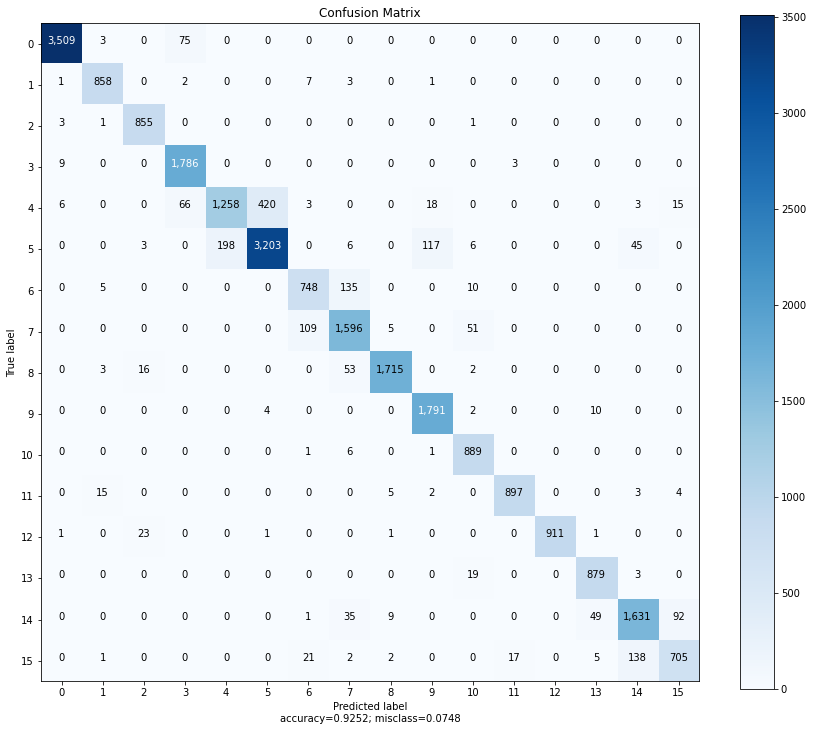

3

{'acc': 0.9253339767456055, 'loss': 0.20762008428573608}

'validation'

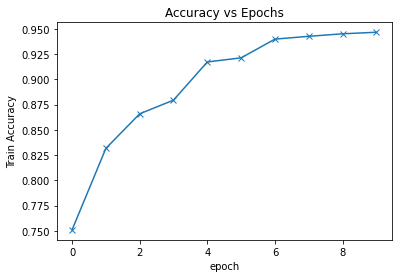

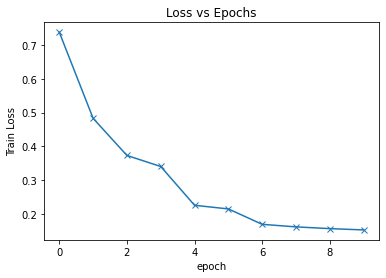

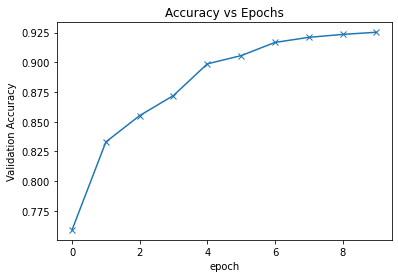

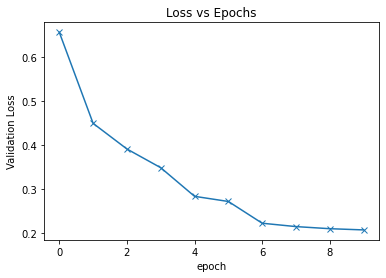

In [ ]:
train_history, validation_history =  train_and_validate_model(4, 0.1, model, train_loader, validation_loader, train_history, validation_history)

In [ ]:
# plot_history_metrics(train_history, 'Train')
# plot_history_metrics(validation_history, 'Validation')

0

{'acc': 0.9390845894813538, 'loss': 0.16497501730918884}

'train'


Confusion Matrix
[[3542    3    0   42    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  857    0    1    1    0    6    4    0    2    0    0    0    0
     0    0]
 [   1    0  856    0    1    1    0    0    0    0    1    0    0    0
     0    0]
 [  12    0    0 1780    3    0    0    0    0    0    0    3    0    0
     0    0]
 [   9    0    0   60 1201  489    3    0    0   18    0    0    0    0
     6    3]
 [   0    0    3    0  177 3278    0    3    0   90    0    0    0    0
    27    0]
 [   1    4    0    0    0    0  728  155    0    0   10    0    0    0
     0    0]
 [   0    0    0    0    0    1   76 1640    2    0   41    0    0    1
     0    0]
 [   0    1   15    0    0    0    0   71 1701    0    1    0    0    0
     0    0]
 [   0    0    0    0    1   16    0    0    0 1782    0    0    0    8
     0    0]
 [   0    0    0    0    0    0    1    6    0    4  886    0    0    0
     0    0]
 [   0   14    0    0    0    1    0    0    5 

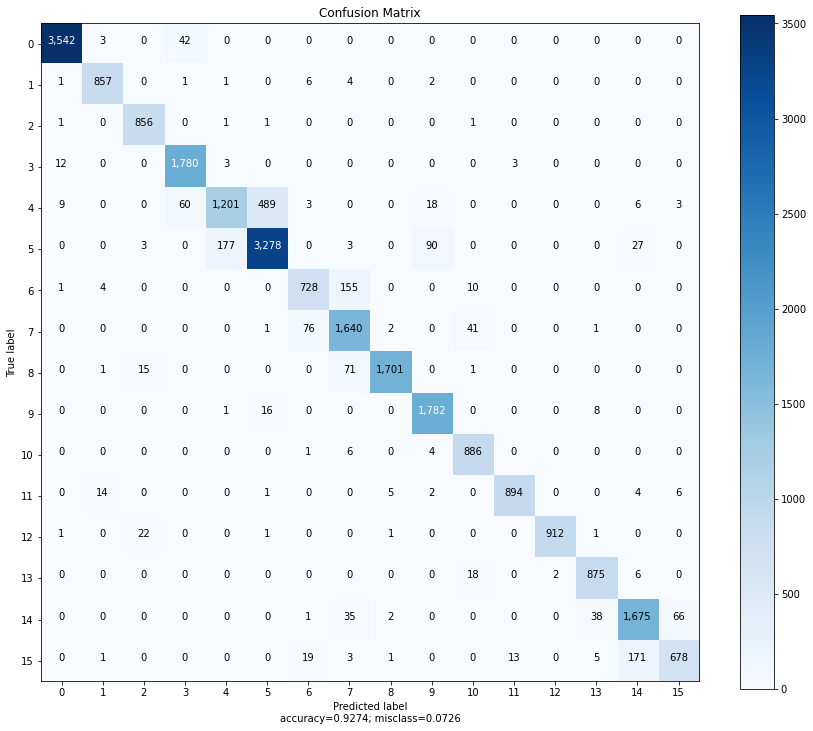

0

{'acc': 0.9273995161056519, 'loss': 0.19207142293453217}

'validation'

1

{'acc': 0.9401447176933289, 'loss': 0.16194331645965576}

'train'


Confusion Matrix
[[3542    3    0   42    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  856    0    2    1    0    6    4    0    2    0    0    0    0
     0    0]
 [   1    0  856    0    1    1    0    0    0    0    1    0    0    0
     0    0]
 [  15    0    0 1777    3    0    0    0    0    0    0    3    0    0
     0    0]
 [   9    0    0   60 1210  483    0    0    0   18    0    0    0    0
     6    3]
 [   0    0    3    0  177 3278    0    3    0   90    0    0    0    0
    27    0]
 [   1    4    0    0    0    0  728  155    0    0   10    0    0    0
     0    0]
 [   0    0    0    0    0    1   76 1640    2    0   41    0    0    1
     0    0]
 [   0    2   15    0    0    0    0   69 1702    0    1    0    0    0
     0    0]
 [   0    0    0    0    1   16    0    0    0 1782    0    0    0    8
     0    0]
 [   0    0    0    0    0    0    1    6    0    4  886    0    0    0
     0    0]
 [   0   14    0    0    0    1    0    0    5 

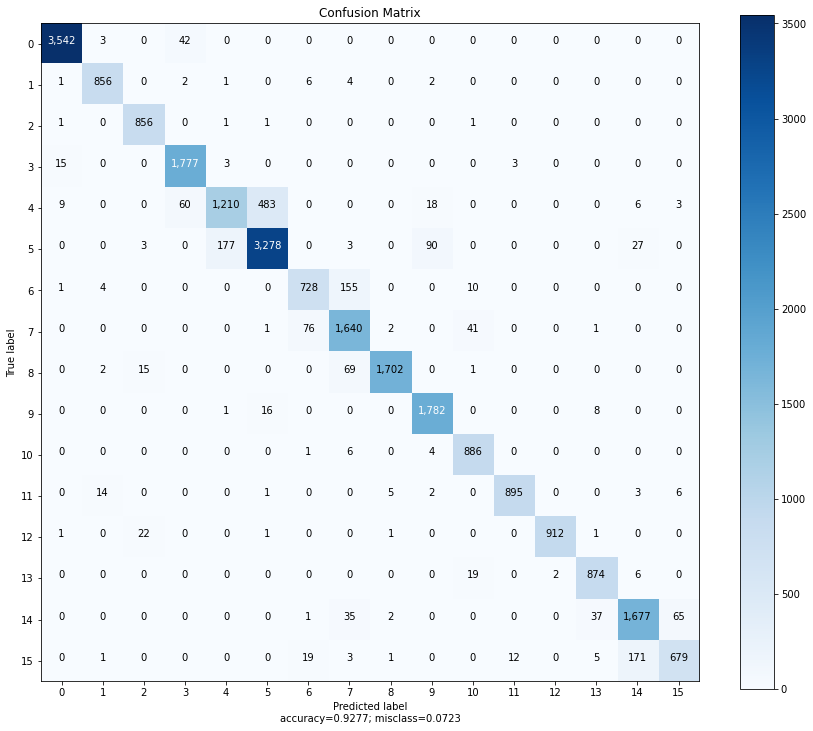

1

{'acc': 0.9277573823928833, 'loss': 0.19039133191108704}

'validation'

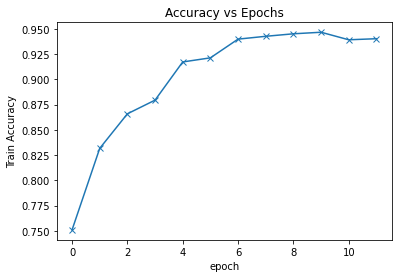

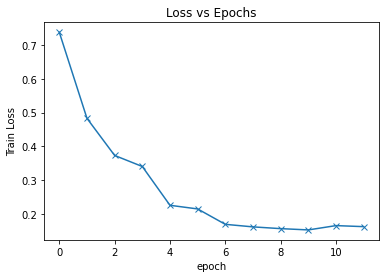

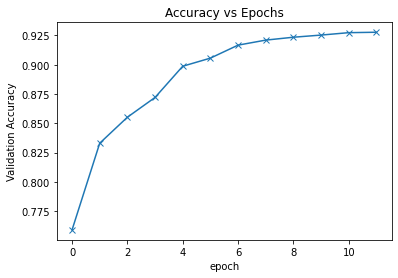

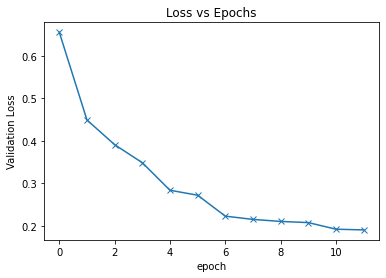

In [ ]:
train_history, validation_history =  train_and_validate_model(2, 0.01, model, train_loader, validation_loader, train_history, validation_history)

0

{'acc': 0.9391610026359558, 'loss': 0.16563133895397186}

'train'


Confusion Matrix
[[3542    3    0   42    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  857    0    1    1    0    6    4    0    2    0    0    0    0
     0    0]
 [   1    0  856    0    1    1    0    0    0    0    1    0    0    0
     0    0]
 [  15    0    0 1777    3    0    0    0    0    0    0    3    0    0
     0    0]
 [   9    0    0   60 1306  384    3    0    0   18    0    0    0    0
     3    6]
 [   0    0    3    0  255 3221    0    9    0   63    0    0    0    0
    27    0]
 [   1    4    0    0    0    0  746  137    0    0   10    0    0    0
     0    0]
 [   0    0    0    0    0    1   91 1631    2    0   35    0    0    1
     0    0]
 [   0    3   14    0    0    0    0   71 1700    0    1    0    0    0
     0    0]
 [   0    0    0    0    1   35    0    1    0 1762    0    0    0    8
     0    0]
 [   0    0    0    0    0    0    1    8    0    4  884    0    0    0
     0    0]
 [   0   15    0    0    0    1    0    0    4 

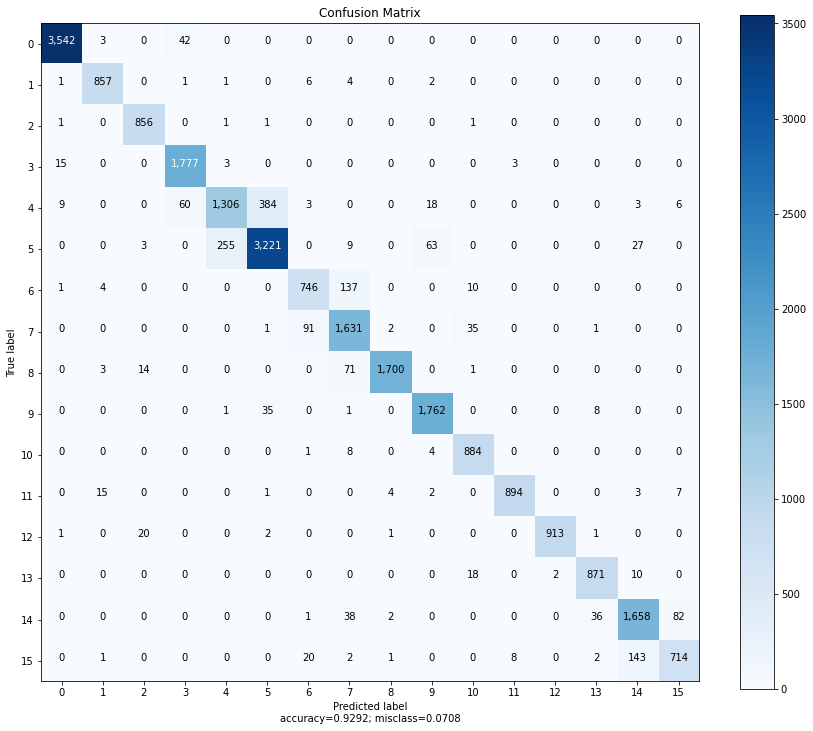

0

{'acc': 0.9293495416641235, 'loss': 0.183001309633255}

'validation'

1

{'acc': 0.939294695854187, 'loss': 0.1644316464662552}

'train'


Confusion Matrix
[[3542    3    0   42    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1  857    0    1    1    0    6    4    0    2    0    0    0    0
     0    0]
 [   1    0  856    0    1    1    0    0    0    0    1    0    0    0
     0    0]
 [  15    0    0 1777    3    0    0    0    0    0    0    3    0    0
     0    0]
 [   9    0    0   60 1303  387    3    0    0   18    0    0    0    0
     3    6]
 [   0    0    3    0  252 3224    0    9    0   63    0    0    0    0
    27    0]
 [   1    3    0    0    0    0  748  136    0    0   10    0    0    0
     0    0]
 [   0    0    0    0    0    1   91 1632    2    0   34    0    0    1
     0    0]
 [   0    3   13    0    0    0    0   71 1701    0    1    0    0    0
     0    0]
 [   0    0    0    0    1   35    0    1    0 1762    0    0    0    8
     0    0]
 [   0    0    0    0    0    0    1    8    0    4  884    0    0    0
     0    0]
 [   0   16    0    0    0    1    0    0    4 

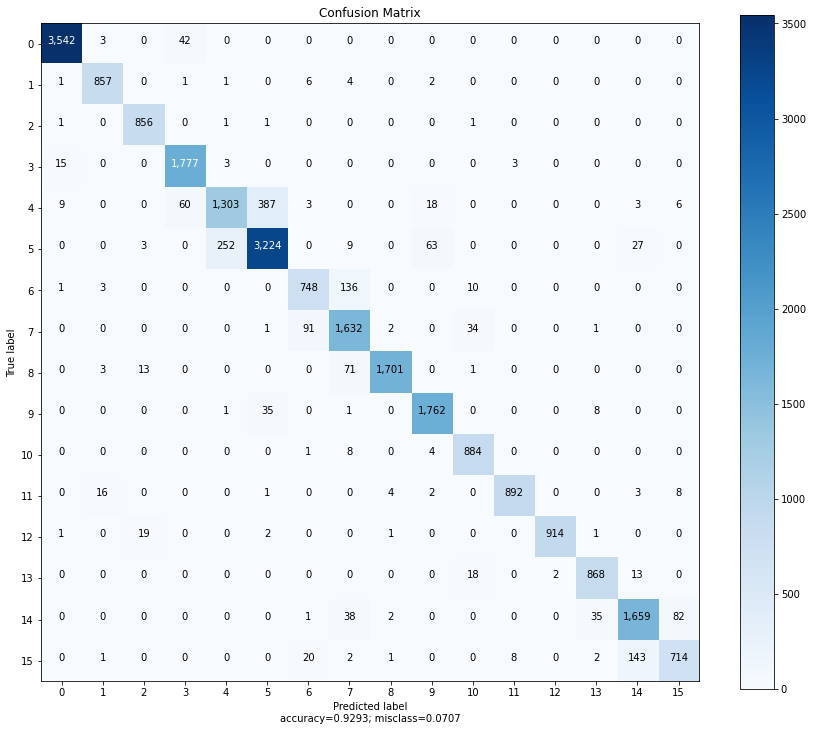

1

{'acc': 0.9293892979621887, 'loss': 0.1826297640800476}

'validation'

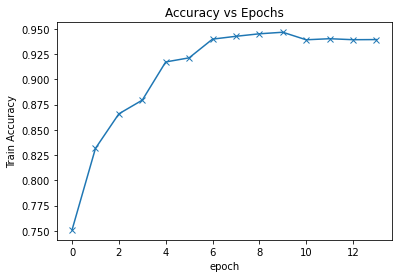

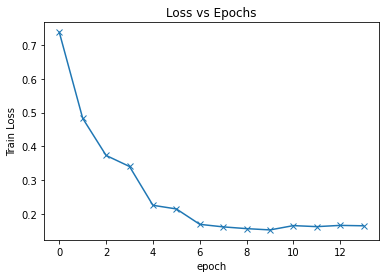

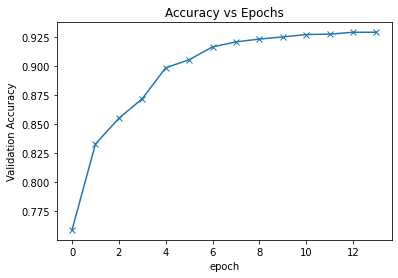

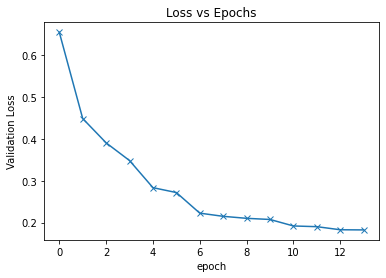

In [ ]:
train_history, validation_history =  train_and_validate_model(2, 0.001, model, train_loader, validation_loader, train_history, validation_history)


Confusion Matrix
[[3498    0    9    9    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0  808    0    4    1    0    8    5    3    0    0    0    0    0
     0    0]
 [   5    0  851    0    1    4    0    0    2    0    1    0    0    0
     0    0]
 [  36    0    0 1722    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   6    0    0   48 1300  392    0    0    0   12    0    0    0    0
     0    0]
 [   0    0    0    0  199 3096    0    0    0  215    0    0    0    0
     6    0]
 [   0    3    0    0    0    0  717  156    0    0   15    0    0    0
     0    0]
 [   0    1    0    0    0    0  115 1557    1    0   85    0    0    1
     1    0]
 [   0   22   14    0    0    0    2   73 1637    0   10    0    0    0
     0    0]
 [   0    0    0    0    5   54    0    0    0 1694    0    0    0    3
     2    0]
 [   0    0    2    0    0    0    2   46    1    1  824    0    0    0
     0    0]
 [   2   17    1    1    0    0    0    0    6 

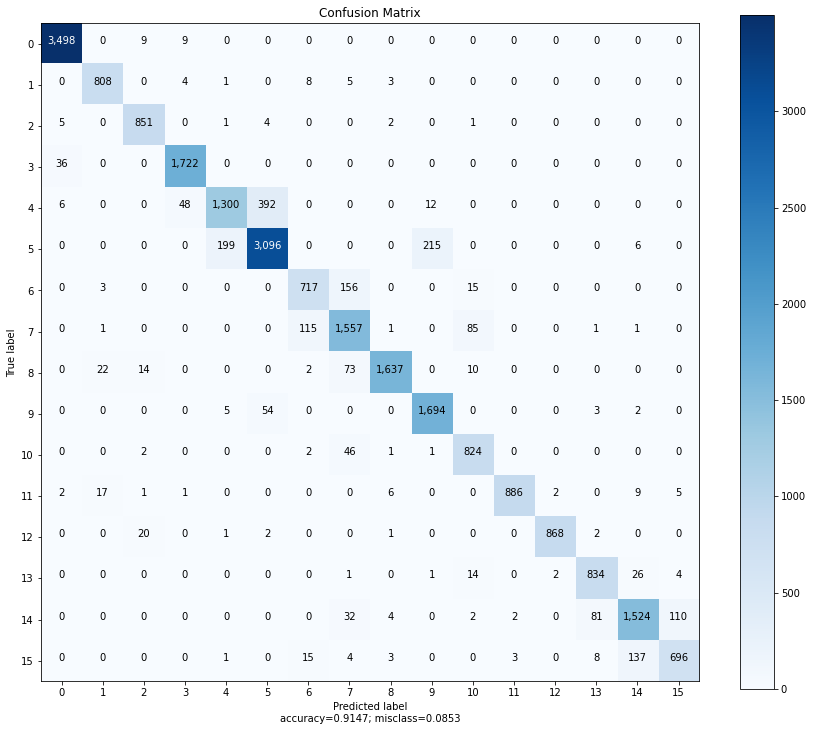

1

{'acc': 0.9146464467048645, 'loss': 0.2196008861064911}

'validation'

{'acc': 0.9146464467048645, 'loss': 0.2196008861064911}

In [ ]:
evaluate(model, test_loader, 1)